I will built an ITEM-based movie recommendation. The algorithm finds the most similar movies to a given movie.

The "number of rating" attribute is not so relevant in my opinion, because the dataset contains a lot of popular movies without any rating. To find the best solution, I decided to develop an algorithm that can be fine tuned with weights for each used attrributes.

In [1]:
# To store and manipulate the data 
import pandas as pd 

# To do linear algebra
import numpy as np 

# Plotting and visualization Library
import matplotlib.pyplot as plt
import seaborn as sns

# To check if a string contains the specified search pattern
import re

# Compute distance between each pair of the two collections of input
from scipy import spatial

# To import images to jupyter notebook
from IPython.display import Image

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')



from wordcloud import WordCloud, STOPWORDS #used to generate world cloud

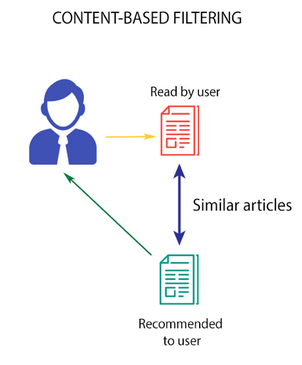

In [2]:
# Example of a Content-Based
Image(filename ="../Images/ContentBasedFiltering.png", width=300, height=10)

In [3]:
df_ratings = pd.read_csv("../Input/ratings.csv")
df_links = pd.read_csv("../Input/links.csv")
df_tags = pd.read_csv("../Input/tags.csv")
df_movies = pd.read_csv("../Input/movies.csv")

All ratings are contained in the file ratings.csv. Each line of this file after the header row represents one rating of one movie by one user, and has the following format:

userId,movieId,rating,timestamp
The lines within this file are ordered first by userId, then, within user, by movieId.

Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).

Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

In [4]:
print(df_ratings.shape)
df_ratings.head(2)

(1048575, 4)


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676


All tags are contained in the file tags.csv. Each line of this file after the header row represents one tag applied to one movie by one user, and has the following format:

userId,movieId,tag,timestamp
The lines within this file are ordered first by userId, then, within user, by movieId.

Tags are user-generated metadata about movies. Each tag is typically a single word or short phrase. The meaning, value, and purpose of a particular tag is determined by each user.

Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

In [5]:
print(df_tags.shape)
df_tags.head(2)

(465564, 4)


,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078


Movie information is contained in the file movies.csv. Each line of this file after the header row represents one movie, and has the following format:

movieId,title,genres
Movie titles are entered manually or imported from https://www.themoviedb.org/, and include the year of release in parentheses. Errors and inconsistencies may exist in these titles.

Genres are a pipe-separated list, and are selected from the following:

* Action
* Adventure
* Animation
* Children's
* Comedy
* Crime
* Documentary
* Drama
* Fantasy
* Film-Noir
* Horror
* Musical
* Mystery
* Romance
* Sci-Fi
* Thriller
* War
* Western
* (no genres listed)


In [6]:
print(df_movies.shape)
df_movies.head(2)

(27278, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


Identifiers that can be used to link to other sources of movie data are contained in the file links.csv. Each line of this file after the header row represents one movie, and has the following format:

movieId,imdbId,tmdbId
movieId is an identifier for movies used by https://movielens.org. E.g., the movie Toy Story has the link https://movielens.org/movies/1.

imdbId is an identifier for movies used by http://www.imdb.com. E.g., the movie Toy Story has the link http://www.imdb.com/title/tt0114709/.

tmdbId is an identifier for movies used by https://www.themoviedb.org. E.g., the movie Toy Story has the link https://www.themoviedb.org/movie/862.

Use of the resources listed above is subject to the terms of each provider.

In [7]:
print(df_links.shape)
df_links.head(2)

(27278, 3)


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0


In [8]:
# We can see that we have 1.048.575 total ratings, mean of 3.5, min rating is 0.5 and max rating is 5.0
pd.options.display.float_format = '{:f}'.format
df_ratings['rating'].describe()

count   1048575.000000
mean          3.529272
std           1.051919
min           0.500000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

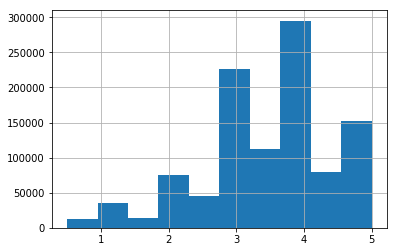

In [9]:
# Displaying rating in histogram
df_ratings['rating'].hist()

## Ratings group by


#### Movie ratings aggregated by user:

In [10]:
# Creating a variable name user_ratings_total that will contain all the ratings that a specific userid 
# rated(.groupby) and we will also add(.agg) the ratings size and mean([np.size, np.mean]).
user_ratings_total = df_ratings.groupby(['userId']).agg({'rating': [np.size, np.mean]})
user_ratings_total.reset_index(inplace=True)  # To reset multilevel (pivot-like) index
user_ratings_total.head(2)

userId     rating         
               size     mean
0      1 175.000000 3.742857
1      2  61.000000 4.000000

In [11]:
user_ratings_total['rating'].describe()

,size,mean
count,7120.000000,7120.000000
mean,147.271770,3.620345
std,220.808148,0.448493
min,20.000000,0.600000
25%,35.000000,3.360000
50%,69.000000,3.650000
75%,161.000000,3.922854
max,2711.000000,5.000000


size       AxesSubplot(0.125,0.125;0.352273x0.755)
mean    AxesSubplot(0.547727,0.125;0.352273x0.755)
dtype: object

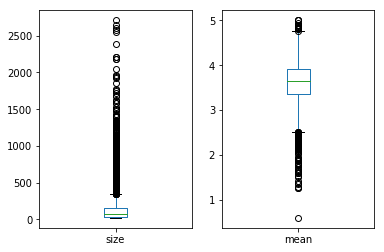

In [12]:
user_ratings_total['rating'].plot(kind='box', subplots=True)

### Movie ratings by movie:

In [13]:
# Creating a variable name movie_ratings_total  that will contain all the ratings that a specific movieid 
# has(.groupby) and we will also add(.agg) the ratings size and mean([np.size, np.mean]).
movie_ratings_total = df_ratings.groupby(['movieId']).agg({'rating': [np.size, np.mean]})
movie_ratings_total.reset_index(inplace=True)
movie_ratings_total.head(3)

movieId      rating         
                 size     mean
0       1 2569.000000 3.959323
1       2 1155.000000 3.268398
2       3  685.000000 3.186861

In [14]:
movie_ratings_total['rating'].describe()

,size,mean
count,14026.000000,14026.000000
mean,74.759375,3.214934
std,218.188441,0.790743
min,1.000000,0.500000
25%,2.000000,2.833333
50%,9.000000,3.363636
75%,43.000000,3.750000
max,3498.000000,5.000000


## Movies (master data)

#### Join movie rating data

In [15]:
# Merging df_movies with movie_ratings_total
df_movies_final = df_movies.merge(movie_ratings_total, left_on='movieId', right_on='movieId', how='left')

# Changing names on columns
df_movies_final.columns = ['movieId', 'title', 'genres', 'rating_count', 'rating_avg']

In [16]:
df_movies_final.head()

,movieId,title,genres,rating_count,rating_avg
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2569.000000,3.959323
1,2,Jumanji (1995),Adventure|Children|Fantasy,1155.000000,3.268398
2,3,Grumpier Old Men (1995),Comedy|Romance,685.000000,3.186861
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,138.000000,3.000000
4,5,Father of the Bride Part II (1995),Comedy,657.000000,3.143836


#### Get movie years from title

In [17]:
def get_year(title):
    result = re.search(r'\(\d{4}\)', title)
    if result:
        found = result.group(0).strip('(').strip(')')
    else: 
        found = 0
    return int(found)
    
df_movies_final['year'] = df_movies_final.apply(lambda x: get_year(x['title']), axis=1)

In [18]:
# List of genres
genres_list = [
  "Action",
  "Adventure",
  "Animation",
  "Children",
  "Comedy",
  "Crime",
  "Documentary",
  "Drama",
  "Fantasy",
  "Film-Noir",
  "Horror",
  "Musical",
  "Mystery",
  "Romance",
  "Sci-Fi",
  "Thriller",
  "War",
  "Western",
  "(no genres listed)"
]

At this step I create a "genresMatrix" field where every value is a list of binary values (19 elements in every list, for the 19 possible genres). For example a movie with genres "Action", "Comedy" and "Fantasy" will look like: [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] . We call this "one hot encoding" (Dummy).

This matrix will be very useful to define the similarities between two "genres" sets. For this purpose I'm going to compute the Cosine distance between the given arrays. More info: SciPy spatial.distance.cosine

#### Create genres matrix - one hot encoding (Dummy)

In [19]:
# Creating a function that will be filled by [0,1] based on the actual movie genres.
def set_genres_matrix(genres):
    movie_genres_matrix = []
    movie_genres_list = genres.split('|')
    for x in genres_list:
        if (x in movie_genres_list):
            movie_genres_matrix.append(1)
        else:
            movie_genres_matrix.append(0) 
    return movie_genres_matrix

In [20]:
# Applying set_genres_matrix function to add a genres_matrix column to the df_movies_final
df_movies_final['genres_matrix'] = df_movies_final.apply(lambda x: np.array(list(set_genres_matrix(x['genres']))), axis=1)


In [21]:
df_movies_final.head()

,movieId,title,genres,rating_count,rating_avg,year,genres_matrix
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2569.000000,3.959323,1995,"[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,1155.000000,3.268398,1995,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,3,Grumpier Old Men (1995),Comedy|Romance,685.000000,3.186861,1995,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,138.000000,3.000000,1995,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."
4,5,Father of the Bride Part II (1995),Comedy,657.000000,3.143836,1995,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


#### Set rating categories
##### Based on the number of user ratings per movie, I have defined 7 rating groups.

Check the distribution of ratings per movie

In [ ]:
#movie_ratings_total['rating'].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99])


#### The desired rating number groups will be:

* 0 - not rated movie
* 1 - count of ratings between 1 - 10
* 2 - count of ratings between 11 - 30
* 3 - count of ratings between 31 - 100
* 4 - count of ratings between 101 - 300
* 5 - count of ratings between 301 - 1000
* 6 - count of ratings between 1001 -

In [ ]:
def set_rating_group(number_of_ratings):
    if (number_of_ratings is None): return 0
    if (1 <= number_of_ratings <= 10): return 1
    elif (11 <= number_of_ratings <= 30): return 2
    elif (31 <= number_of_ratings <= 100): return 3
    elif (101 <= number_of_ratings <= 300): return 4
    elif (301 <= number_of_ratings <= 1000): return 5
    elif (1001 <= number_of_ratings): return 6
    else: return 0

df_movies_final['rating_group'] = df_movies_final.apply(lambda x: set_rating_group(x['rating_count']), axis=1)
df_movies_final.fillna(0, inplace=True)  # Replace NaN values to zero


In [ ]:
df_movies_final.head(10)

#### Tags
Iterate through all the user given tags, split the tags into words, filter the stop words and put the results into a dictionary by movieId.

In [ ]:
# Stopwords are the English words which does not add much meaning to a sentence. 
# They can safely be ignored without sacrificing the meaning of the sentence.
#def get_stop_words():
stop_words = ['a', 'about', 'above', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 
        'alone', 'along', 'already', 'also','although','always','am','among', 'amongst', 'amoungst', 'amount',  'an', 'and', 
        'another', 'any','anyhow','anyone','anything','anyway', 'anywhere', 'are', 'around', 'as',  'at', 'back','be','became', 
        'because','become','becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 
        'between', 'beyond', 'bill', 'both', 'bottom','but', 'by', 'call', 'can', 'cannot', 'cant', 'co', 'con', 'could', 'couldnt', 
        'cry', 'de', 'describe', 'detail', 'do', 'done', 'down', 'due', 'during', 'each', 'eg', 'eight', 'either', 'eleven','else', 
        'elsewhere', 'empty', 'enough', 'etc', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 
        'fify', 'fill', 'find', 'fire', 'first', 'five', 'for', 'former', 'formerly', 'forty', 'found', 'four', 'from', 'front', 'full', 
        'further', 'get', 'give', 'go', 'had', 'has', 'hasnt', 'have', 'he', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', 'hereupon', 
        'hers', 'herself', 'him', 'himself', 'his', 'how', 'however', 'hundred', 'ie', 'if', 'in', 'inc', 'indeed', 'interest', 'into', 'is', 'it', 
        'its', 'itself', 'keep', 'last', 'latter', 'latterly', 'least', 'less', 'ltd', 'made', 'many', 'may', 'me', 'meanwhile', 'might', 'mill', 
        'mine', 'more', 'moreover', 'most', 'mostly', 'move', 'much', 'must', 'my', 'myself', 'name', 'namely', 'neither', 'never', 'nevertheless',
        'next', 'nine', 'no', 'nobody', 'none', 'noone', 'nor', 'not', 'nothing', 'now', 'nowhere', 'of', 'off', 'often', 'on', 'once', 'one', 
        'only', 'onto', 'or', 'other', 'others', 'otherwise', 'our', 'ours', 'ourselves', 'out', 'over', 'own','part', 'per', 'perhaps', 'please', 
        'put', 'rather', 're', 'same', 'see', 'seem', 'seemed', 'seeming', 'seems', 'serious', 'several', 'she', 'should', 'show', 'side', 'since', 
        'sincere', 'six', 'sixty', 'so', 'some', 'somehow', 'someone', 'something', 'sometime', 'sometimes', 'somewhere', 'still', 'such', 'system', 
        'take', 'ten', 'than', 'that', 'the', 'their', 'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 'therefore', 'therein', 
        'thereupon', 'these', 'they', 'thickv', 'thin', 'third', 'this', 'those', 'though', 'three', 'through', 'throughout', 'thru', 'thus', 'to', 
        'together', 'too', 'top', 'toward', 'towards', 'twelve', 'twenty', 'two', 'un', 'under', 'until', 'up', 'upon', 'us', 'very', 'via', 'was', 
        'we', 'well', 'were', 'what', 'whatever', 'when', 'whence', 'whenever', 'where', 'whereafter', 'whereas', 'whereby', 'wherein', 'whereupon', 
        'wherever', 'whether', 'which', 'while', 'whither', 'who', 'whoever', 'whole', 'whom', 'whose', 'why', 'will', 'with', 'within', 'without', 'would', 
        'yet', 'you', 'your', 'yours', 'yourself', 'yourselves', 'the']

In [ ]:
tags_dict = {}

for index, x in df_tags.iterrows():
    word_list = str(x['tag']).lower().split(' ')
    movieId = x['movieId']
    for y in word_list:
        if y not in stop_words:
            if movieId in tags_dict:
                # if y not in tagsDict[movieId]:  # Switched off (we will get a non unique list)
                    tags_dict[movieId].append(y)
            else:
                tags_dict[movieId] = [y]

df_tags.apply(lambda x: str(x['tag']).split(' '), axis=1)
print(tags_dict[2])

In [ ]:
import json

# a Python object (dict):
tags_dict

# convert into JSON:
y = json.dumps(tags_dict)

In [ ]:
#with open('data.json', 'w') as fp:
    #json.dump(y, fp)

In [ ]:
#with open('data.json', 'r') as f:
   # a = json.load(f)

In [ ]:
title_words_dict = {}

for index, x in df_movies.iterrows():
    word_list = str(x['title']).lower().split(' ')
    movieId = x['movieId']
    for y in word_list:
        if y not in stop_words:
            if movieId in title_words_dict:
                title_words_dict[movieId].append(y)
            else:
                title_words_dict[movieId] = [y]
print(title_words_dict[1])

In [ ]:
# Assigning 
# Parameter weights

genresSimilarityWeight = 0.8
tagsSimilarityWeight = 2
titleSimilarityWeight = 1
ratingAvgWeight = 0.2
ratingGroupWeight = 0.005
yearDistanceWeight = 0.1
    

def tags_similarity(basisMovieID, checkedMovieID, checkType):    
    # The higher value is the more similar (from 0 to 1) 
    if checkType == 'tag':
        dictToCheck = tags_dict
    else:
        dictToCheck = title_words_dict
        
    counter = 0
    if basisMovieID in dictToCheck: 
        basisTags = dictToCheck[basisMovieID]
        countAllTags = len(basisTags)
        basisTagsDict = {}
        for x in basisTags:
            if x in basisTagsDict:
                basisTagsDict[x] += 1
            else:
                basisTagsDict[x] = 1   
        
        for x in basisTagsDict:
            basisTagsDict[x] = basisTagsDict[x] / countAllTags
    else: return 0
    
    if checkedMovieID in dictToCheck: 
        checkedTags = dictToCheck[checkedMovieID]
        checkedTags = set(checkedTags) # Make the list unique
        checkedTags = list(checkedTags)
        
    else: return 0
    
    for x in basisTagsDict:
        if x in checkedTags: counter += basisTagsDict[x]
    return counter
    
def check_similarity(movieId):
    
    print("SIMILAR MOVIES TO:")
    print (df_movies_final[df_movies_final['movieId'] == movieId][['title', 'rating_count', 'rating_avg']])
    basisGenres = np.array(list(df_movies_final[df_movies_final['movieId'] == movieId]['genres_matrix']))
    basisYear = int(df_movies_final[df_movies_final['movieId'] == movieId]['year'])
    basisRatingAvg = df_movies_final[df_movies_final['movieId'] == movieId]['rating_avg']
    basisRatingGroup = df_movies_final[df_movies_final['movieId'] == movieId]['rating_group']
    
    moviesWithSim = df_movies_final
    moviesWithSim['similarity'] = moviesWithSim.apply(lambda x: 
                                                      spatial.distance.cosine(x['genres_matrix'], basisGenres) * genresSimilarityWeight + 
                                                      - tags_similarity(movieId, x['movieId'], 'tag') * tagsSimilarityWeight +
                                                      - tags_similarity(movieId, x['movieId'], 'title') * titleSimilarityWeight +
                                                      abs(basisRatingAvg - x['rating_avg']) * ratingAvgWeight +
                                                      abs(basisRatingGroup - x['rating_group']) * ratingGroupWeight + 
                                                      abs(basisYear - x['year'])/100 * yearDistanceWeight
                                                     , axis=1)
    
    moviesWithSim = moviesWithSim.loc[(moviesWithSim.movieId != movieId)]
    return moviesWithSim[['movieId', 'title', 'genres', 'rating_count', 'rating_avg', 'similarity']].sort_values('similarity')


In [ ]:
currentMovie = df_movies_final.loc[(df_movies_final.movieId == 22)]
currentMovie.head(1)

In [ ]:
currentMovie2 = df_movies_final.loc[(df_movies_final.title == 'Toy Story (1995)')]
currentMovie2.head(1)

In [ ]:
movie_user_wants = input('Enter a movie: ')

In [ ]:
movie_user_wants

In [ ]:
result = df_movies_final.loc[df_movies_final['title'] == movie_user_wants]
print(result)
movie__id__= int(result['movieId'])

In [ ]:
similarityResult1  = check_similarity(movie__id__)
similarityResult1.head()

In [ ]:
for x in df_movies_final.title:
    if 'Batman' in x:
        print(x)


In [ ]:
# Toy Story
similarityResult  = check_similarity(1)
similarityResult.head()

In [ ]:
#define a function that counts the number of times each genre appear:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue
        for s in liste_keywords: 
            if pd.notnull(s): keyword_count[s] += 1
    # convert the dictionary in a list to sort the keywords  by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count


In [ ]:
 #here we  make census of the genres:
genre_labels = set()
for s in df_movies_final['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

In [ ]:
#counting how many times each of genres occur:
keyword_occurences, dum = count_word(df_movies_final, 'genres', genre_labels)
#keyword_occurences

In [ ]:
# Function that control the color of the words
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)


#Result shown as a wordcloud:
words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 20 # define the color of the words
f, ax = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=550,height=300, background_color='white', 
                      max_words=1628,relative_scaling=0.7,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()



In [ ]:
# same result but in the histogram
fig = plt.figure(1, figsize=(18,13))
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("# of occurences", fontsize = 24, labelpad = 0)
ax2.bar(x_axis, y_axis, align = 'center', color='b')
plt.title("Popularity",bbox={'facecolor':'w', 'pad':2},color='b',fontsize = 35)
plt.show()

In [ ]:
sns.jointplot(x='rating_avg', y='rating_count', data=df_movies_final)

In [ ]:
df_movies_final

In [ ]:
# df_movies_final.to_csv('df_movies_final.csv')